In [98]:
import torch
import numpy
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize
from typing import Tuple

In [99]:
t_c_list = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0] #temperature data in celsius
t_u_list = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] #temperature data in unknown units
t_c = torch.tensor(t_c_list)
t_u = torch.tensor(t_u_list)

In [100]:
#Define our linear model function
def model(x:torch.Tensor, w:torch.Tensor, b:torch.Tensor)->torch.Tensor:
    #Weight and bias
    return w*x + b

popt, pcov = scipy.optimize.curve_fit(model, t_u_list, t_c_list, p0=(1,1))

pearson_r, p = scipy.stats.pearsonr(t_u_list, t_c_list)

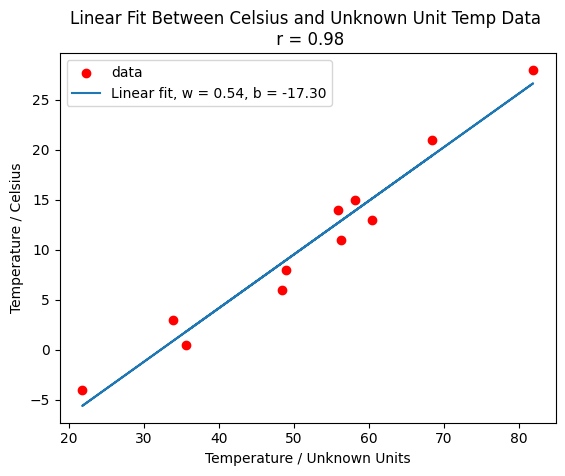

In [101]:
plt.scatter(t_u, t_c, label = 'data', color='r')
plt.plot(t_u, model(t_u, popt[0], popt[1]), label = f'Linear fit, w = {popt[0]:.2f}, b = {popt[1]:.2f}')
plt.ylabel('Temperature / Celsius')
plt.xlabel('Temperature / Unknown Units')
plt.title(f'Linear Fit Between Celsius and Unknown Unit Temp Data \n r = {pearson_r:.2f}')
plt.legend()
plt.show()

In [102]:
#Define the loss function
def loss_fn(t_p:torch.Tensor, t_c:torch.Tensor)->torch.Tensor:
    sqr_diff = (t_p - t_c)**2
    return sqr_diff.mean()

#Define the derivative of the loss function
def dloss_fn(t_p:torch.Tensor, t_c:torch.Tensor)->torch.Tensor:
    dsqr_diff = 2 * (t_p - t_c) / t_c.shape[0]
    return dsqr_diff

#Derivatives of model wrt parameters
def dmodel_dw(t_u, w, b)->torch.Tensor:
    "Derivative of t_p wrt to w"
    return t_u

def dmodel_db(t_u, w, b)->torch.Tensor:
    "Derivative of t_p wrt b"
    return 1.0

#Definition of gradient, using the 
def grad_function(t_u, t_c, t_p, w, b):
    "Calculates the gradients of the loss wrt w and b and returns the loss sums as stacks"
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b) #Using chain rule
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    """Performs n_epochs iterations of gradient descent and returns the estimated parameters"""
    for _ in range (n_epochs):
        w, b = params

        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_function(t_u, t_c, t_p, w, b)

        params = params - learning_rate * grad

        print(f'Epoch: {_}, Loss: {loss} \n\
              Params: {params}\n\
              Grad: {grad}')
    
    return params, loss


In [103]:
n_epochs = 5000
learning_rate = 1e-2
params = torch.tensor([1.0, 0.0]) #Initial guesses of w and b
t_u_norm = t_u * 0.1

#Run the loop
params, final_loss = training_loop(n_epochs, learning_rate, params, t_u_norm, t_c)
w = params[0]
b = params[1]

Epoch: 0, Loss: 80.36434173583984 
              Params: tensor([1.7761, 0.1064])
              Grad: tensor([-77.6140, -10.6400])
Epoch: 1, Loss: 37.574913024902344 
              Params: tensor([2.0848, 0.1303])
              Grad: tensor([-30.8623,  -2.3864])
Epoch: 2, Loss: 30.871076583862305 
              Params: tensor([2.2094, 0.1217])
              Grad: tensor([-12.4631,   0.8587])
Epoch: 3, Loss: 29.756193161010742 
              Params: tensor([2.2616, 0.1004])
              Grad: tensor([-5.2218,  2.1327])
Epoch: 4, Loss: 29.507152557373047 
              Params: tensor([2.2853, 0.0740])
              Grad: tensor([-2.3715,  2.6310])
Epoch: 5, Loss: 29.3924560546875 
              Params: tensor([2.2978, 0.0458])
              Grad: tensor([-1.2492,  2.8241])
Epoch: 6, Loss: 29.298828125 
              Params: tensor([2.3059, 0.0168])
              Grad: tensor([-0.8071,  2.8970])
Epoch: 7, Loss: 29.208717346191406 
              Params: tensor([ 2.3122, -0.0124])
        

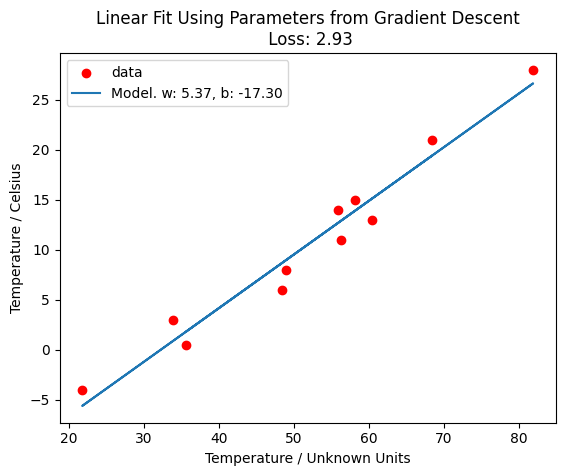

In [104]:
plt.scatter(t_u, t_c, label = 'data', color='r')
plt.plot(t_u, model(t_u_norm, w, b), label = f'Model. w: {w:.2f}, b: {b:.2f}')
plt.ylabel('Temperature / Celsius')
plt.xlabel('Temperature / Unknown Units')
plt.title(f'Linear Fit Using Parameters from Gradient Descent\n Loss: {final_loss:.2f}')
plt.legend()
plt.show()

<h1>PyTorch Autograd</h1>
Saves us the trouble of computing the gradient manually.

In [105]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for _ in range(n_epochs):
        if params.grad is not None: #Make sure to zero the gradients to prevent accumulation
            params.grad.zero_()
        
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()

        with torch.no_grad():
            params -= learning_rate * params.grad

        if (_ + 1) % 500 == 0:
            print(f'Epoch: {_+1}, Loss: {loss} \n\
                Params: {params}\n\
                Grad: {params.grad}')
        
    return params, loss
        

In [106]:
n_epochs = 5000
learning_rate = 1e-2
params = torch.tensor([1.0, 0.0], requires_grad=True) #setting requires_grad=True allows daughter tensors to have genetic memory

params_f, loss_f = training_loop(
    n_epochs, 
    learning_rate, 
    params, 
    t_u_norm, 
    t_c)

w = params_f[0].detach().numpy()
b = params_f[1].detach().numpy()

w, b

Epoch: 500, Loss: 7.860115051269531 
                Params: tensor([ 4.0443, -9.8133], requires_grad=True)
                Grad: tensor([-0.2252,  1.2748])
Epoch: 1000, Loss: 3.828537940979004 
                Params: tensor([  4.8021, -14.1031], requires_grad=True)
                Grad: tensor([-0.0962,  0.5448])
Epoch: 1500, Loss: 3.092191219329834 
                Params: tensor([  5.1260, -15.9365], requires_grad=True)
                Grad: tensor([-0.0411,  0.2328])
Epoch: 2000, Loss: 2.957697868347168 
                Params: tensor([  5.2644, -16.7200], requires_grad=True)
                Grad: tensor([-0.0176,  0.0995])
Epoch: 2500, Loss: 2.933133840560913 
                Params: tensor([  5.3236, -17.0549], requires_grad=True)
                Grad: tensor([-0.0075,  0.0425])
Epoch: 3000, Loss: 2.9286484718322754 
                Params: tensor([  5.3489, -17.1980], requires_grad=True)
                Grad: tensor([-0.0032,  0.0182])
Epoch: 3500, Loss: 2.9278297424316406 
   

(array(5.3670845, dtype=float32), array(-17.301193, dtype=float32))

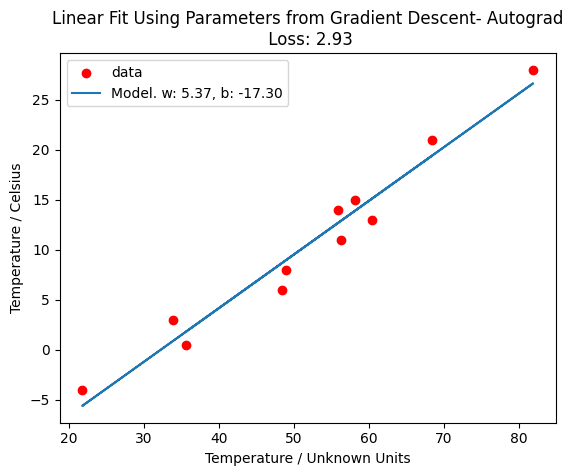

In [107]:
plt.scatter(t_u, t_c, label = 'data', color='r')
plt.plot(t_u, model(t_u_norm, *params.detach().numpy()), label = f'Model. w: {params[0]:.2f}, b: {params[1]:.2f}')
plt.ylabel('Temperature / Celsius')
plt.xlabel('Temperature / Unknown Units')
plt.title(f'Linear Fit Using Parameters from Gradient Descent- Autograd\n Loss: {final_loss:.2f}')
plt.legend()
plt.show()

In [108]:
import torch.optim as optim

In [109]:
def training_loop(n_epochs:int, optimizer, params:torch.Tensor, t_u:torch.Tensor, t_c:torch.Tensor)->Tuple[torch.Tensor, float]:
    """Uses a specified optimizer in order to train """

    for _ in range(n_epochs):

        #generate predictions
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)

        #Make sure to zero the gradients to prevent accumulation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (_ + 1) % 500 == 0:
            print(f'Epoch: {_+1}, Loss: {loss} \n\
                Params: {params}\n\
                Grad: {params.grad}')

    return params, loss

In [110]:
n_epochs = 5000
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2

#Use Stochastic Gradient Descent Optimizer
optimizer = optim.SGD([params], lr=learning_rate)

params_f, loss_f = training_loop(n_epochs, optimizer, params, t_u_norm, t_c)

params_f, loss_f

Epoch: 500, Loss: 7.860119819641113 
                Params: tensor([ 4.0443, -9.8133], requires_grad=True)
                Grad: tensor([-0.2252,  1.2748])
Epoch: 1000, Loss: 3.828537940979004 
                Params: tensor([  4.8021, -14.1031], requires_grad=True)
                Grad: tensor([-0.0962,  0.5448])
Epoch: 1500, Loss: 3.092191219329834 
                Params: tensor([  5.1260, -15.9365], requires_grad=True)
                Grad: tensor([-0.0411,  0.2328])
Epoch: 2000, Loss: 2.957697868347168 
                Params: tensor([  5.2644, -16.7200], requires_grad=True)
                Grad: tensor([-0.0176,  0.0995])
Epoch: 2500, Loss: 2.933133840560913 
                Params: tensor([  5.3236, -17.0549], requires_grad=True)
                Grad: tensor([-0.0075,  0.0425])
Epoch: 3000, Loss: 2.9286484718322754 
                Params: tensor([  5.3489, -17.1980], requires_grad=True)
                Grad: tensor([-0.0032,  0.0182])
Epoch: 3500, Loss: 2.9278297424316406 
   

(tensor([  5.3671, -17.3012], requires_grad=True),
 tensor(2.9276, grad_fn=<MeanBackward0>))

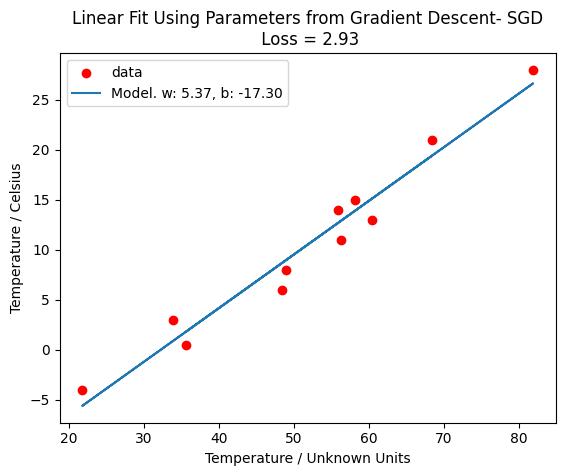

In [111]:
plt.scatter(t_u, t_c, label = 'data', color='r')
plt.plot(t_u, model(t_u_norm, *params.detach().numpy()), label = f'Model. w: {params[0]:.2f}, b: {params[1]:.2f}')
plt.ylabel('Temperature / Celsius')
plt.xlabel('Temperature / Unknown Units')
plt.title(f'Linear Fit Using Parameters from Gradient Descent- SGD\n Loss = {loss_f:.2f}')
plt.legend()
plt.show()

In [112]:
n_epochs = 5000
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1

#ADAM allows us to use the unnormalised values of the unknown temperature readings
optimizer = optim.Adam([params], lr=learning_rate)

params_f, loss_f = training_loop(n_epochs, optimizer, params, t_u, t_c)

params_f, loss_f

Epoch: 500, Loss: 7.6128997802734375 
                Params: tensor([  0.4081, -10.0095], requires_grad=True)
                Grad: tensor([-1.1792,  1.2604])
Epoch: 1000, Loss: 3.086698293685913 
                Params: tensor([  0.5131, -15.9629], requires_grad=True)
                Grad: tensor([-0.2153,  0.2323])
Epoch: 1500, Loss: 2.9285776615142822 
                Params: tensor([  0.5350, -17.2022], requires_grad=True)
                Grad: tensor([-0.0165,  0.0178])
Epoch: 2000, Loss: 2.9276463985443115 
                Params: tensor([  0.5367, -17.3021], requires_grad=True)
                Grad: tensor([-0.0003,  0.0005])
Epoch: 2500, Loss: 2.927645206451416 
                Params: tensor([  0.5368, -17.3047], requires_grad=True)
                Grad: tensor([-1.3733e-04,  1.1742e-05])
Epoch: 3000, Loss: 2.9276459217071533 
                Params: tensor([  0.5368, -17.3047], requires_grad=True)
                Grad: tensor([-1.6785e-04,  8.1658e-06])
Epoch: 3500, Loss: 2.

(tensor([  0.5368, -17.3048], requires_grad=True),
 tensor(2.9276, grad_fn=<MeanBackward0>))

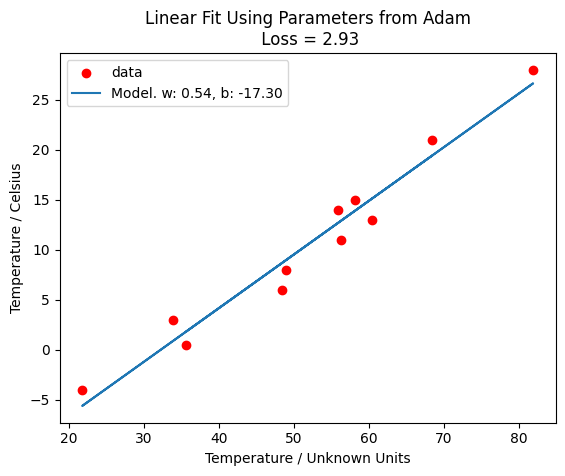

In [113]:
plt.scatter(t_u, t_c, label = 'data', color='r')
plt.plot(t_u, model(t_u, *params.detach().numpy()), label = f'Model. w: {params[0]:.2f}, b: {params[1]:.2f}')
plt.ylabel('Temperature / Celsius')
plt.xlabel('Temperature / Unknown Units')
plt.title(f'Linear Fit Using Parameters from Adam\n Loss = {loss_f:.2f}')
plt.legend()
plt.show()

<h1>Validation and Training Sets</h1>
We now look at splitting the data so that we can reserve some of our data for validation on top of the data that we have already used for training the model.

In [114]:
n_samples = t_u.shape[0] #Number of samples is equal to the length of the t_u tensor
n_val = int(0.2 * n_samples) #Number of data points which we want to reserve for validation

torch.manual_seed(1024)

shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices


(tensor([7, 2, 1, 0, 4, 6, 3, 5, 9]), tensor([ 8, 10]))

In [115]:
#Set aside for training
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

#Set aside for validation
val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

In [121]:
def training_loop(n_epochs:int, optimizer, params:torch.Tensor, train_t_u:torch.Tensor, val_t_u:torch.Tensor, train_t_c:torch.Tensor, 
                  val_t_c:torch.Tensor)->Tuple[torch.Tensor, float]:
    """Uses a specified optimizer in order to train """

    for _ in range(n_epochs):

        #generate predictions
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)

        with torch.no_grad():
            #generate predictions
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False

        #Make sure to zero the gradients to prevent accumulation
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if (_ + 1) % 500 == 0 or (_ + 1) <= 3:
            print(f'Epoch: {_+1}, Training Loss: {train_loss.item():.2f}, Validation Loss: {val_loss.item():.2f}')

    return params

In [124]:
n_epochs = 3000
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1

optimizer = optim.Adam([params], lr=learning_rate)

params_f = training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c)

params_f

Epoch: 1, Training Loss: 1706.47, Validation Loss: 2022.26
Epoch: 2, Training Loss: 1293.06, Validation Loss: 1520.13
Epoch: 3, Training Loss: 939.98, Validation Loss: 1092.99
Epoch: 500, Training Loss: 6.16, Validation Loss: 11.37
Epoch: 1000, Training Loss: 2.51, Validation Loss: 6.12
Epoch: 1500, Training Loss: 2.44, Validation Loss: 5.48
Epoch: 2000, Training Loss: 2.44, Validation Loss: 5.45
Epoch: 2500, Training Loss: 2.44, Validation Loss: 5.44
Epoch: 3000, Training Loss: 2.44, Validation Loss: 5.44


tensor([  0.5234, -16.5090], requires_grad=True)

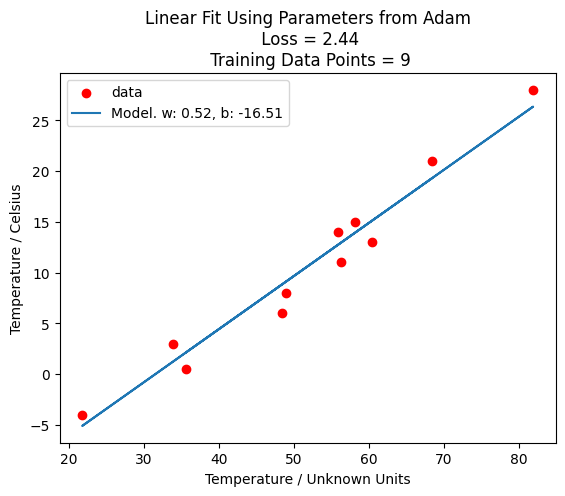

In [125]:
plt.scatter(t_u, t_c, label = 'data', color='r')
plt.plot(t_u, model(t_u, *params.detach().numpy()), label = f'Model. w: {params[0]:.2f}, b: {params[1]:.2f}')
plt.ylabel('Temperature / Celsius')
plt.xlabel('Temperature / Unknown Units')
plt.title(f'Linear Fit Using Parameters from Adam\n Loss = {loss_f:.2f}\n Training Data Points = {len(train_indices)}')
plt.legend()
plt.show()